In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
train_data= r"D:\DL\brain tumor MRI images\Training"
test_data= r"D:\DL\brain tumor MRI images\Testing"

#shuffle training data
train_paths=[]
train_labels=[]
for label in os.listdir(train_data):
    for image in os.listdir(os.path.join(train_data,label)):
        train_paths.append(os.path.join(train_data,label,image))
        train_labels.append(label)
train_paths, train_labels=shuffle(train_paths, train_labels)

#shuffle test data
test_paths=[]
test_labels=[]
for label in os.listdir(test_data):
    for image in os.listdir(os.path.join(test_data,label)):
        test_paths.append(os.path.join(test_data,label,image))
        test_labels.append(label)
test_paths, test_labels=shuffle(test_paths, test_labels)

[3314, 2225, 5468, 2838, 1980, 208, 4582, 2646, 5639, 3201]


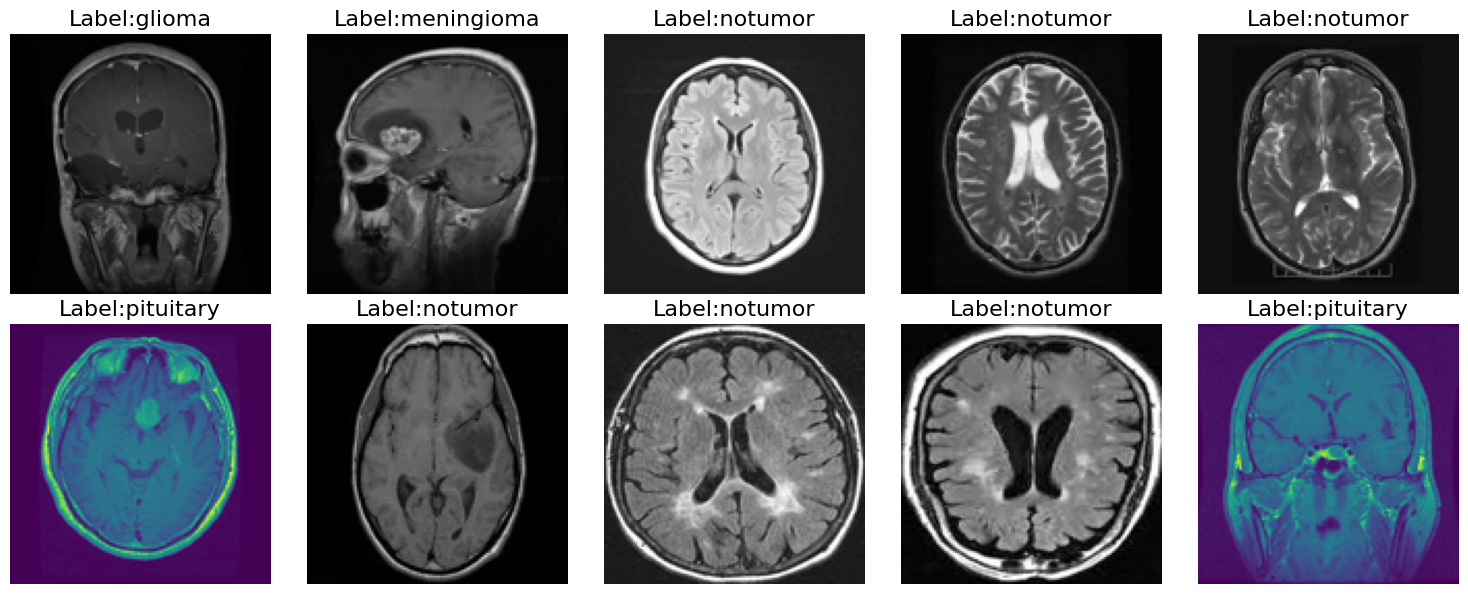

In [66]:
# select 10 random indices
random_indices = random.sample(range(len(train_paths)), 10)
print(random_indices)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Loop through random indices and display image
for i, index in enumerate(random_indices):
    img_path = train_paths[index]
    img = Image.open(img_path)
    img = img.resize((126, 126))
    # Display images
    axes[i].imshow(img)          
    axes[i].axis("off")
    axes[i].set_title(f"Label:{train_labels[index]}",fontsize=16)

plt.tight_layout()
plt.show()

In [33]:
#image aumentation
def augment_image(image):
    image=Image.fromarray(np.uint8(image))
    image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image=np.array(image)/255.0
    return image

#load images and apply augmnetation
def open_images(paths):
    images=[]
    for path in paths:
        img=load_img(path, target_size=(image_size,image_size))
        img=augment_image(img)
        images.append(img)
    return np.array(images)

#encoding labels
def encode_label(labels, class_names):
    return [class_names.index(label) for label in labels]

#batching data
def datagen(paths, labels, batch_size=12, epochs=1):
    class_names = os.listdir(train_data)  # Get class names from directory
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i+batch_size]
            batch_labels = encode_label(batch_labels, class_names)  # Pass class_names
            yield batch_images, np.array(batch_labels)  # Convert labels to numpy array

In [34]:
image_size=126
base_model=VGG16(input_shape=(image_size,image_size,3), include_top=False, weights="imagenet")

#freezing all layers of base model
for layer in base_model.layers:
    layer.trainable=False

#setting the last few layers
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

#model building
model=Sequential()
model.add(Input(shape=(image_size,image_size,3))) #input layer
model.add(base_model) #VGG16 model
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(126,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_data)),activation="softmax")) #output layer

#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

batch_size=20
steps=int(len(train_paths)/batch_size)
epochs=5

#training the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                  epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 99s 341ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.7317
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 95s 333ms/step - loss: 0.2713 - sparse_categorical_accuracy: 0.9000
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 94s 331ms/step - loss: 0.1933 - sparse_categorical_accuracy: 0.9276
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 94s 331ms/step - loss: 0.1120 - sparse_categorical_accuracy: 0.9566
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 95s 332ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9703


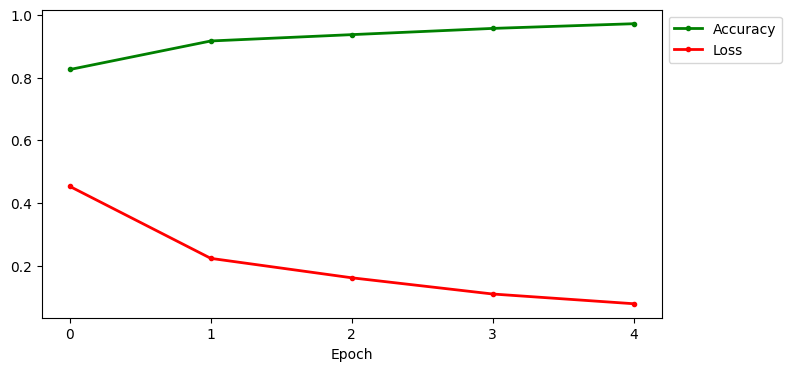

In [44]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["sparse_categorical_accuracy"], ".g-", linewidth=2, label="Accuracy")
plt.plot(history.history["loss"], ".r-", linewidth=2, label="Loss")
plt.legend(['Accuracy', 'Loss'], loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Epoch")
plt.xticks([x for x in range(epochs)])
plt.show()

In [67]:
#get class names from the training directory
class_names = os.listdir(train_data)

#classification report
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels, class_names)  
test_predictions = model.predict(test_images)
print("Classification Report")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 624ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       300
           1       0.93      0.94      0.94       306
           2       0.99      1.00      1.00       405
           3       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



Confusion Matrix
[[279  20   0   1]
 [  9 290   3   4]
 [  0   1 404   0]
 [  1   2   0 297]]


Text(70.72222222222221, 0.5, 'True class')

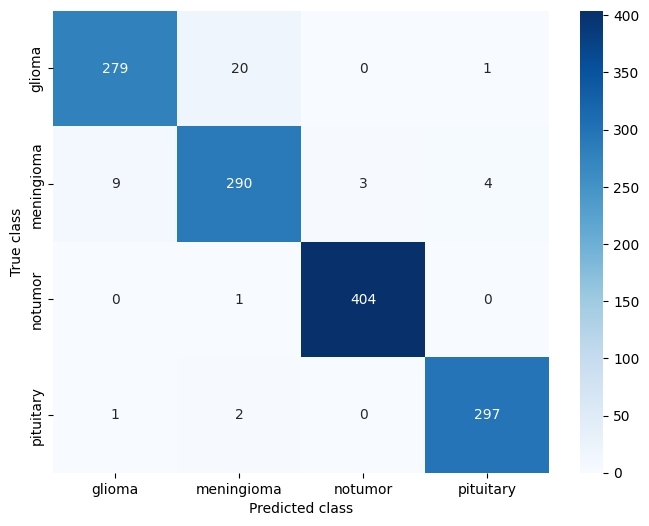

In [52]:
#plot confusion matrix
conf_matrix=confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix")
print(conf_matrix)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_data), yticklabels=os.listdir(train_data))
plt.xlabel("Predicted class")
plt.ylabel("True class")

In [68]:
class_labels=["glioma","meningioma","notumor","pituitry"]

def detect_and_display(image_path, model):
    try:
        #load the image
        img = load_img(image_path, target_size=(126, 126)) 
        img_array = img_to_array(img) / 255.0 
        img_array = np.expand_dims(img_array, axis=0)  

        #prediction 
        predictions = model.predict(img_array)  
        predicted_class_index = np.argmax(predictions)
        confidence_score = np.max(predictions)  

        #determine the class
        if class_labels[predicted_class_index] == "notumor":
            result = "No Tumor Detected"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        #display result
        plt.imshow(load_img(image_path))  
        plt.axis("off")
        plt.title(f"{result} (Confidence: {confidence_score*100:.2f}%)")  
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


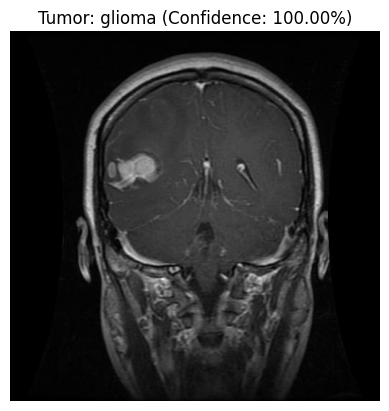

In [62]:
#checking on test data
image_path = r"D:\DL\brain tumor MRI images\Testing\glioma\Te-gl_0037.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


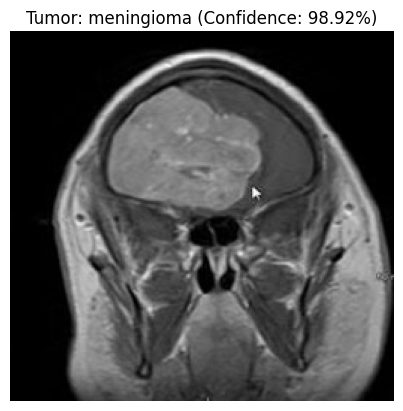

In [63]:
image_path = r"D:\DL\brain tumor MRI images\Testing\meningioma\Te-me_0063.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


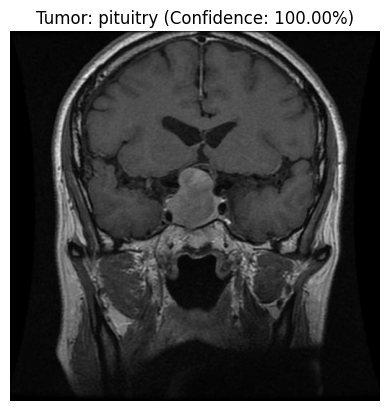

In [64]:
image_path = r"D:\DL\brain tumor MRI images\Testing\pituitary\Te-pi_0204.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


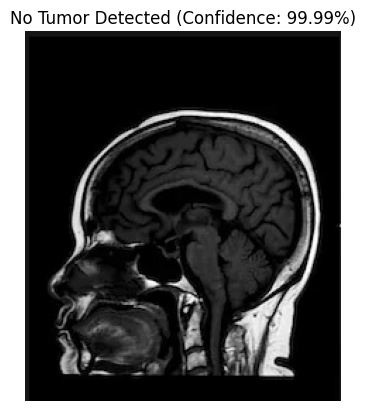

In [65]:
image_path = r"D:\DL\brain tumor MRI images\Testing\notumor\Te-noTr_0004.jpg"
detect_and_display(image_path, model)